In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import skew
from sklearn import preprocessing
import pandas as pd
import networkx as nx
import seaborn as sns
from scipy.linalg import eigh
import math
import random
from tqdm import tqdm

# Initial extraction of time series

In [194]:
import os
import pandas as pd
from tqdm import tqdm
import re
# Función para encontrar archivos en un directorio
def find_files(path):
    files = []
    for dirName, subdirList, fileList in os.walk(path):
        files.extend([os.path.join(dirName, f) for f in fileList])
    return files

# Rutas de los directorios a leer
path_files = ['../data/raw/COP_Tests/HG', '../data/raw/COP_Tests/DG', '../data/raw/COP_Tests/DNG']

# Lista para almacenar filas de datos
rows = []

# Diccionario para mapear los índices a las clases correspondientes
class_map = {0: 'Healthy', 1: 'Diabetic', 2: 'Neuropathic'}

# Leer los archivos y construir filas de datos
for i, path in enumerate(path_files):
    files = find_files(path)
    for file in tqdm(files, desc=f'Processing {path}'):
        with open(file, 'r') as f:
            next(f)  # Saltar la primera línea del archivo
            # Leer las líneas del archivo
            lines = f.readlines()
            # Crear listas para almacenar las series de tiempo X y Y
            X_series = []
            Y_series = []
            # Obtener el nombre del examen del archivo
            exam_name = os.path.basename(file).split('.')[0]  # Obtener el nombre sin la extensión
            # Iterar sobre las líneas y extraer los valores de X y Y
            for line in lines:
                # Dividir la línea en los valores de tiempo, X y Y
                values = line.strip().split(';')
                # Convertir los valores de X e Y a float y almacenarlos en las listas respectivas
                X_series.append(float(values[1].replace(',', '.')))
                Y_series.append(float(values[2].replace(',', '.')))
            # Crear una nueva fila de datos con la clase, la ruta del archivo, el nombre del examen y las series de tiempo
            row = {'class': class_map[i], 'file_path': file, 'exam': exam_name, 'cop_x': X_series, 'cop_y': Y_series}
            rows.append(row)

# Crear DataFrame a partir de las filas de datos
timeSeries = pd.DataFrame(rows)
def clean_exam_name(exam_name):
    # Eliminar 'SWARII'
    exam_name = exam_name.replace('SWARII', '')
    # Eliminar caracteres no alfabéticos excepto espacios
    exam_name = re.sub(r'[^a-zA-Z\s]', '', exam_name)
    # Eliminar espacios adicionales al principio y al final
    exam_name = exam_name.strip()
    return exam_name

# Aplicar la limpieza a la columna 'Exam'
timeSeries['exam'] = timeSeries['exam'].apply(clean_exam_name)

timeSeries = timeSeries.assign(flag='real')
# Guardar el DataFrame resultante en un archivo CSV
timeSeries.to_csv('../data/interim/series_de_tiempo_clasificadas.csv', index=False)

print("Datos almacenados en 'series_de_tiempo_clasificadas.csv'.")


Processing ../data/raw/COP_Tests/HG:   0%|          | 0/87 [00:00<?, ?it/s]

Processing ../data/raw/COP_Tests/DNG: 100%|██████████| 201/201 [00:00<00:00, 909.30it/s]


Datos almacenados en 'series_de_tiempo_clasificadas.csv'.


In [195]:
timeSeries.head(3)

,class,file_path,exam,cop_x,cop_y,flag
0,Healthy,../data/raw/COP_Tests/HG\participant_21\OASETD...,OASETD,"[-0.5907142773263209, -0.5830138724554864, -0....","[0.27127575567479667, 0.23229672622691488, 0.2...",real
1,Healthy,../data/raw/COP_Tests/HG\participant_21\OASE_S...,OASE,"[-0.12162960815483115, -0.12554430626852875, -...","[0.23829658131254128, 0.19021049634102294, 0.1...",real
2,Healthy,../data/raw/COP_Tests/HG\participant_21\OASITD...,OASITD,"[-0.16731413160366831, -0.16177967029908652, -...","[0.8381318584951023, 0.9215735610382687, 1.008...",real


# Acceleration

In [196]:
def add_acceleration_columns(df):
    acc_x_list = []
    acc_y_list = []

    for index, row in df.iterrows():
        x = np.array(row['cop_x'])
        y = np.array(row['cop_y'])
        
        # Calcular las diferencias una vez y dividir por el cuadrado del intervalo de tiempo
        acc_x = np.diff(x) / (0.04)
        acc_y = np.diff(y) / (0.04)
        
        # Agregar un valor inicial de 0 para mantener la longitud de la serie de tiempo
        acc_x = np.insert(acc_x, 0, 0)
        acc_y = np.insert(acc_y, 0, 0)
        
        # Agregar las aceleraciones a las listas
        acc_x_list.append(acc_x)
        acc_y_list.append(acc_y)

    # Asignar las listas de aceleraciones al DataFrame
    df['acc_x'] = acc_x_list
    df['acc_y'] = acc_y_list

In [197]:
add_acceleration_columns(timeSeries)

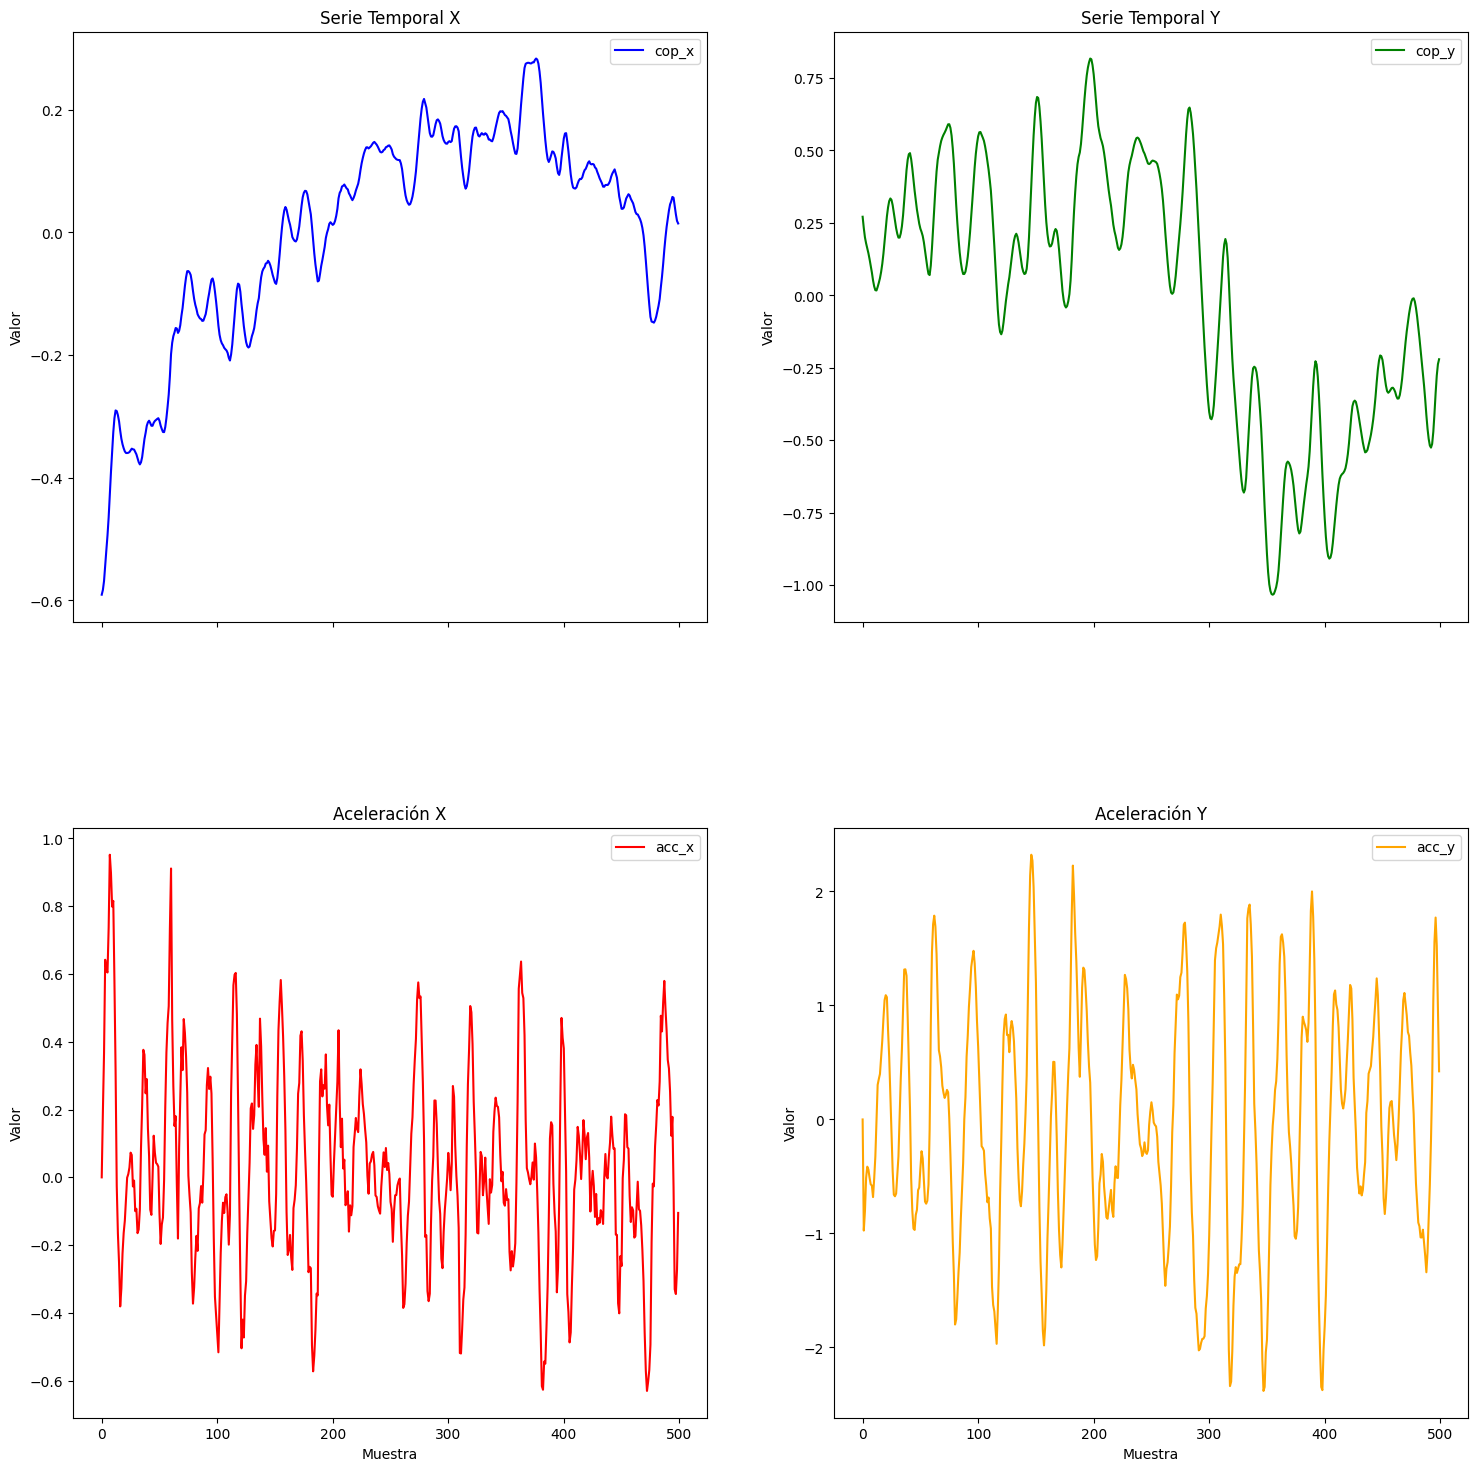

In [198]:
import matplotlib.pyplot as plt

# Obtener los datos de la primera fila
first_row = timeSeries.iloc[0]

# Crear una figura y ejes compartidos
fig, axs = plt.subplots(2, 2, figsize=(18, 18), sharex=True)

# Definir el rango de tiempo
sampled_time = range(500)

# Gráfico de X
axs[0, 0].plot(sampled_time, first_row['cop_x'], label='cop_x', color='blue')
axs[0, 0].set_ylabel('Valor')
axs[0, 0].set_title('Serie Temporal X')
axs[0, 0].legend()

# Gráfico de Y
axs[0, 1].plot(sampled_time, first_row['cop_y'], label='cop_y', color='green')
axs[0, 1].set_ylabel('Valor')
axs[0, 1].set_title('Serie Temporal Y')
axs[0, 1].legend()

# Gráfico de accX
axs[1, 0].plot(sampled_time, first_row['acc_x'], label='acc_x', color='red')
axs[1, 0].set_xlabel('Muestra')
axs[1, 0].set_ylabel('Valor')
axs[1, 0].set_title('Aceleración X')
axs[1, 0].legend()

# Gráfico de accY
axs[1, 1].plot(sampled_time, first_row['acc_y'], label='acc_y', color='orange')
axs[1, 1].set_xlabel('Muestra')
axs[1, 1].set_ylabel('Valor')
axs[1, 1].set_title('Aceleración Y')
axs[1, 1].legend()

plt.subplots_adjust(hspace=0.35)
plt.show()


# RMS acceleration

In [199]:
def add_rms_columns(df):
    rms_x_list = []
    rms_y_list = []

    for index, row in df.iterrows():
        x = np.array(row['acc_x'])
        y = np.array(row['acc_y'])
        rms_x = np.sqrt(np.mean(x ** 2))
        rms_y = np.sqrt(np.mean(y ** 2))
        rms_x_list.append(rms_x)
        rms_y_list.append(rms_y)

    df['rms_acc_x'] = rms_x_list
    df['rms_acc_y'] = rms_y_list
add_rms_columns(timeSeries)

In [200]:
timeSeries.rms_acc_x

0      0.275944
1      0.348282
2      0.584157
3      0.330530
4      0.408705
         ...   
428    0.870562
429    0.816791
430    2.072932
431    1.803191
432    2.289400
Name: rms_acc_x, Length: 433, dtype: float64

# PATH

In [201]:
def add_path_column(df):
    path_list = []

    for index, row in df.iterrows():
        x = np.array(row['cop_x'])
        y = np.array(row['cop_y'])
        path_length = sum(np.sqrt(x ** 2 + y ** 2))
        path_list.append(path_length)

    df['path'] = path_list

add_path_column(timeSeries)

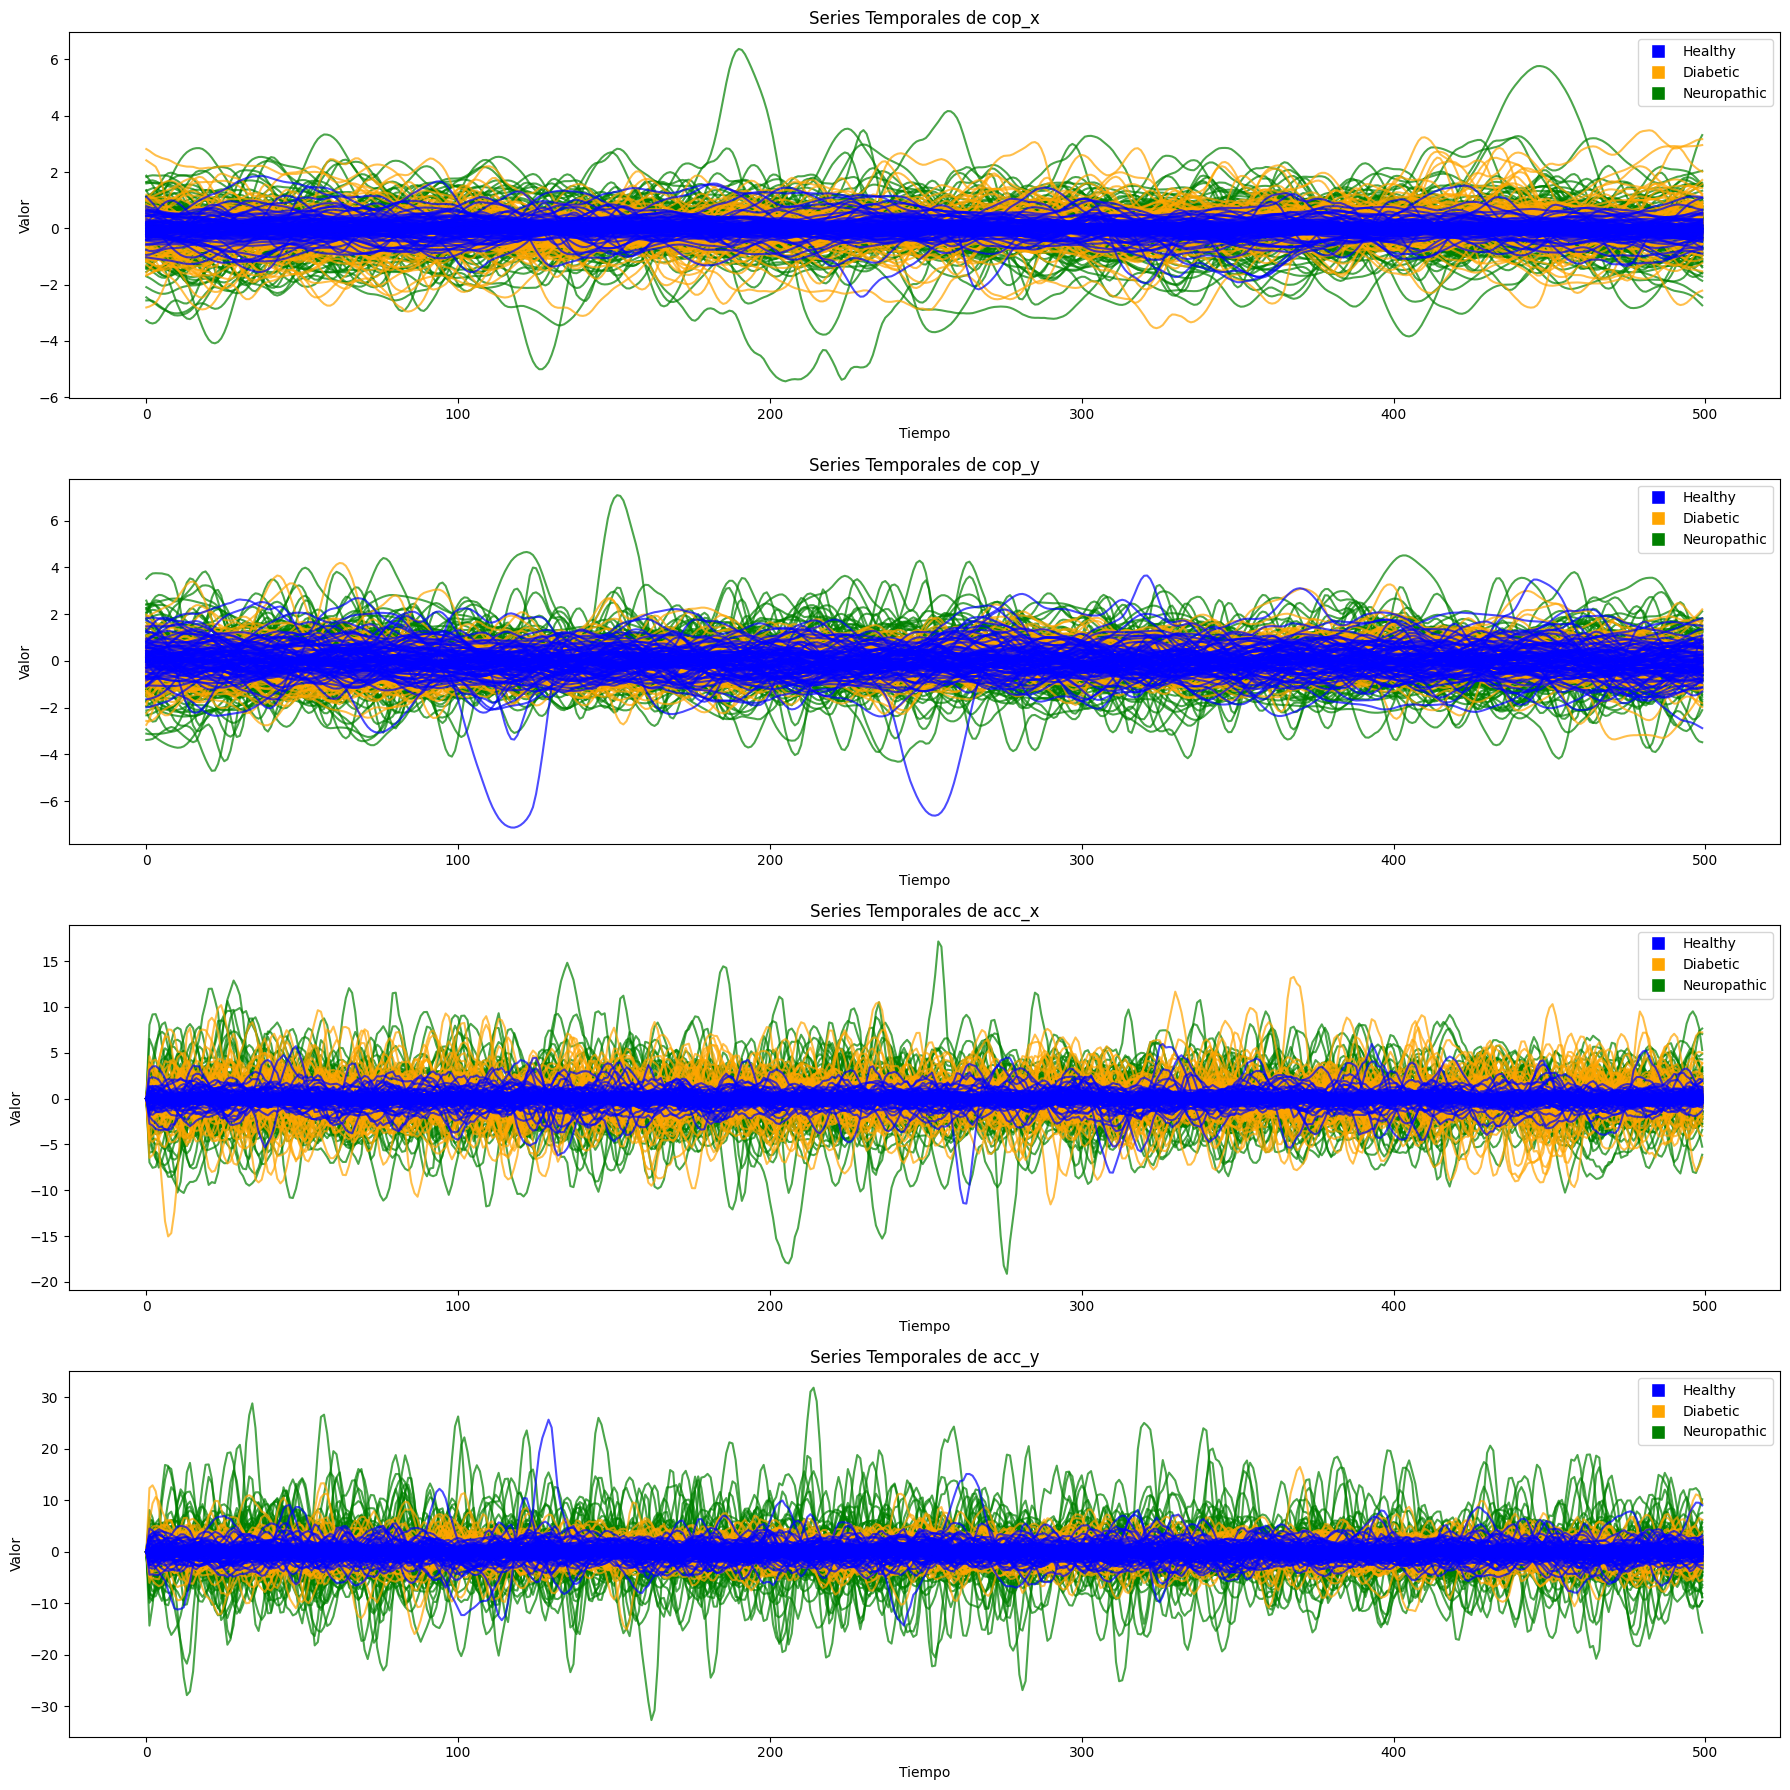

In [202]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

colors = {'Neuropathic': 'green', 'Diabetic': 'orange', 'Healthy': 'blue'}

class_series = {'Neuropathic': [], 'Diabetic': [], 'Healthy': []}

for index, row in timeSeries.iterrows():
    class_label = row['class']
    class_series[class_label].append(row[['cop_x', 'cop_y', 'acc_x', 'acc_y']])

fig, axs = plt.subplots(4, 1, figsize=(18, 18))

class_order = ['Neuropathic', 'Diabetic', 'Healthy']

for class_label in class_order:
    class_data = class_series[class_label]
    for data in class_data:
        x_series, y_series, acc_x_series, acc_y_series = data
        color = colors[class_label]
        axs[0].plot(x_series, label=class_label, color=color, alpha=0.7)
        axs[1].plot(y_series, label=class_label, color=color, alpha=0.7)
        axs[2].plot(acc_x_series, label=class_label, color=color, alpha=0.7)
        axs[3].plot(acc_y_series, label=class_label, color=color, alpha=0.7)

for ax, title in zip(axs, ['cop_x', 'cop_y', 'acc_x', 'acc_y']):
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('Valor')
    ax.set_title('Series Temporales de ' + title)
    legend_elements = [Line2D([0], [0], marker='s', color='w', label='Healthy', markerfacecolor='blue', markersize=10),
                       Line2D([0], [0], marker='s', color='w', label='Diabetic', markerfacecolor='orange', markersize=10),
                       Line2D([0], [0], marker='s', color='w', label='Neuropathic', markerfacecolor='green', markersize=10)]
    ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()



In [203]:
timeSeries.head(1)

,class,file_path,exam,cop_x,cop_y,flag,acc_x,acc_y,rms_acc_x,rms_acc_y,path
0,Healthy,../data/raw/COP_Tests/HG\participant_21\OASETD...,OASETD,"[-0.5907142773263209, -0.5830138724554864, -0....","[0.27127575567479667, 0.23229672622691488, 0.2...",real,"[0.0, 0.19251012177086135, 0.3659675176743149,...","[0.0, -0.9744757361970446, -0.8038894263146634...",0.275944,1.017366,212.701212


In [204]:
import numpy as np

def get_sampen_series(series, m=2, r=0.2):
    """
    Calcula la entropía aproximada (Sample Entropy) para una serie de tiempo.

    Parameters:
        series (list or numpy array): Serie de tiempo.
        m (int): Longitud de la subserie.
        r (float): Umbral de similitud.

    Returns:
        float: Entropía aproximada.
    """
    N = len(series)
    B = 0.0
    A = 0.0
    # Divide la serie temporal y guarda todas las plantillas de longitud m.
    xmi = np.array([series[i : i + m] for i in range(N - m)])
    xmj = np.array([series[i : i + m] for i in range(N - m + 1)])
    # Guarda todas las coincidencias menos la coincidencia propia y calcula B.
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])
    # Similar para calcular A.
    m += 1
    xm = np.array([series[i : i + m] for i in range(N - m + 1)])
    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])
    # Devuelve la entropía aproximada.
    return -np.log(A / B)

# Aplicar la función a la serie temporal X de la primera fila de timeSeries
# Aplicar la función a todas las series de tiempo X e Y en el DataFrame timeSeries
timeSeries['samp_en_x'] = timeSeries['cop_x'].apply(get_sampen_series)
timeSeries['samp_en_y'] = timeSeries['cop_y'].apply(get_sampen_series)



In [205]:
timeSeries.samp_en_y

0      0.130354
1      0.124366
2      0.181430
3      0.166926
4      0.215147
         ...   
428    0.207895
429    0.243884
430    0.304981
431    0.275100
432    0.327360
Name: samp_en_y, Length: 433, dtype: float64

In [206]:
len(timeSeries['cop_x'].iloc[0])

500

# F80 Fourier power spectrum


In [207]:
def get_fft(serie):
    f = np.linspace(0.0, 1.0 / (2.0 * (1 / 25)), 500 // 2)
    power = np.abs(np.fft.fft(serie))[0:500 // 2]
    return f[f <= 4], power[f <= 4]

def get_f80(f, power, min, max):
    return np.sum(power[(f >= min) & (f < max)]) * 4 / 5    

def get_f80_on_column(serie):
    # Obtener las frecuencias y potencias utilizando get_fft
    f, power = get_fft(serie)
    
    # Calcular el f80 utilizando las frecuencias y potencias
    f80 = get_f80(f, power, 0, 4)
    
    return f80


timeSeries['f80_x'] = timeSeries['cop_x'].apply(get_f80_on_column)
timeSeries['f80_y'] = timeSeries['cop_y'].apply(get_f80_on_column)


In [208]:
def get_fft(serie):
    f = np.linspace(0.0, 1.0 / (2.0 * (1 / 25)), 500 // 2)
    power = np.abs(np.fft.fft(serie))[0:500 // 2]
    return f[f <= 4], power[f <= 4]
def get_mean_freq(f, power, min_freq, max_freq):
    mean = np.mean(power[(f >= min_freq) & (f < max_freq)])
    return mean

def add_frequency_features(df, prefix, min_freq, max_freq):
    # Aplicar la función de frecuencia media para las series de tiempo X e Y
    df[f'{prefix}_x'] = df['cop_x'].apply(lambda x: get_mean_freq(*get_fft(x), min_freq, max_freq))
    df[f'{prefix}_y'] = df['cop_y'].apply(lambda y: get_mean_freq(*get_fft(y), min_freq, max_freq))

# Definir los rangos de frecuencia para cada característica
frequency_ranges = {
    'mf_lf': (0, 0.5),
    'mf_mf': (0.5, 2),
    'mf_hf': (2, 4)
}

# Aplicar la función para cada característica y agregar las columnas al DataFrame
for feature, (min_freq, max_freq) in frequency_ranges.items():
    add_frequency_features(timeSeries, feature, min_freq, max_freq)


# Export


In [217]:
timeSeries.to_json('../data/processed/realData.json', orient='records', lines=True)


# Import Example

In [17]:
timeSeries = pd.read_json('../data/processed/realData.json', orient='records', lines=True)

print(timeSeries)

           class                                          file_path      exam  \
0        Healthy  ../data/raw/COP_Tests/HG\participant_21\OASETD...    OASETD   
1        Healthy  ../data/raw/COP_Tests/HG\participant_21\OASE_S...      OASE   
2        Healthy  ../data/raw/COP_Tests/HG\participant_21\OASITD...    OASITD   
3        Healthy  ../data/raw/COP_Tests/HG\participant_21\OCSETD...    OCSETD   
4        Healthy  ../data/raw/COP_Tests/HG\participant_21\OCSE_S...      OCSE   
..           ...                                                ...       ...   
428  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...    EBOCTD   
429  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...    EBOCTD   
430  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...  EBOCTDSI   
431  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...  EBOCTDSI   
432  Neuropathic  ../data/raw/COP_Tests/DNG\participant_20\EBOCT...  EBOCTDSI   

                           